In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
def save_notebook():
    return display(Javascript("IPython.notebook.save_notebook()"),
                   include=['application/javascript'])

def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [4]:
import sys, os
import glob
import warnings
sys.path.append('../')

from rankutils.utilities import merge_kfolds_rounds
from rankutils.rIO import read_rank
from rankutils.cfgloader import cfgloader
from rankutils.drawing import heatmap, annotate_heatmap, tableimg, annotate_tableimg
from rankutils.aggregation import *

import numpy as np
from sklearn.preprocessing import minmax_scale, normalize
from sklearn.metrics import average_precision_score, precision_recall_curve

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange

In [5]:
def get_topk(pathchfg, key, idx, topk):
    
    rkflist = glob.glob(pathcfg.get(key, 'rank') + "*.rk")
    rkflist.sort()
    
    rank = read_rank(rkflist[idx], rows=topk)
    
    return os.path.basename(rkflist[idx]), rank

In [6]:
def get_topk_labels(pathcfg, key, idx, topk):
    
    aux_key = '.'.join(key.split('_', 1))
    
    lblfpath = glob.glob(pathcfg.get(key, 'label') + "*" + aux_key + "*")[0]
    labels = np.load(lblfpath)
    
    return np.array(labels[idx, 0:topk])

In [7]:
def get_topk_predlabels(pathcfg, key, predmethod, idx, topk):
    
    foldfpath = glob.glob(pathcfg.get(key, 'rank') + '*.npy')[0]
    folds = np.load(foldfpath)
        
    respath = "{0:s}{1:s}/".format(pathcfg.get(key, 'output'), predmethod)
    pred_labels = merge_kfolds_rounds(respath, folds)[0]
        
    return pred_labels[idx]

In [8]:
def labels_from_map(labelmap, names):
    
    labels = np.zeros(names.size, dtype=np.uint8)
    
    for i, n in enumerate(names):
        labels[i] = labelmap[n]
        
    return labels

In [9]:
pathcfg = cfgloader("/home/alberto/phD/projects/performance_prediction/ret-mr-learning/source/path_2.cfg")
collection = 'places365'
keys=['places365_001', 'places365_002', 'places365_003', 'places365_004', 'places365_005']

#collection = 'imagenet'
#keys=['imagenet_001', 'imagenet_002', 'imagenet_003', 'imagenet_004']

#collection = 'vggfaces'
#keys=['vggfaces_001', 'vggfaces_003', 'vggfaces_004', 'vggfaces_005']

predmethod = '0004.irp.weibull-fixed'
idx=45
topk=10

In [10]:
rnamelist = []
rscorelist = []
rlabellist = []
rpredlist = []
labelmap = dict()

for k in keys:
    exname, rank = get_topk(pathcfg, k, idx, topk)
    
    rnamelist.append(rank['name'])
    rscorelist.append(1 - normalize(rank['score'].reshape(1, -1)).reshape(-1))
    rlabellist.append(get_topk_labels(pathcfg, k, idx, topk))
    rpredlist.append(get_topk_predlabels(pathcfg, k, predmethod, idx, topk))
    
    for i, name in enumerate(rank['name']):
        if name not in labelmap:
            labelmap[name] = rlabellist[-1][i]

            
resmap = dict()
for i, k in enumerate(keys):
    
    totalrel = np.sum(rlabellist[i])
    patk = totalrel/topk
    apatk = average_precision_score(rlabellist[i], np.linspace(1.0, 0.1, topk))
    
    totalpred = np.sum(rpredlist[i])
    pred_patk = totalpred/topk
    pred_apatk = average_precision_score(rpredlist[i], np.linspace(1.0, 0.1, topk))
    
    resmap[k] = [patk, totalrel, apatk, pred_patk, totalpred, pred_apatk]

/home/alberto/miniconda3/envs/albpy/lib/python3.6/site-packages/sklearn/metrics/ranking.py:526: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


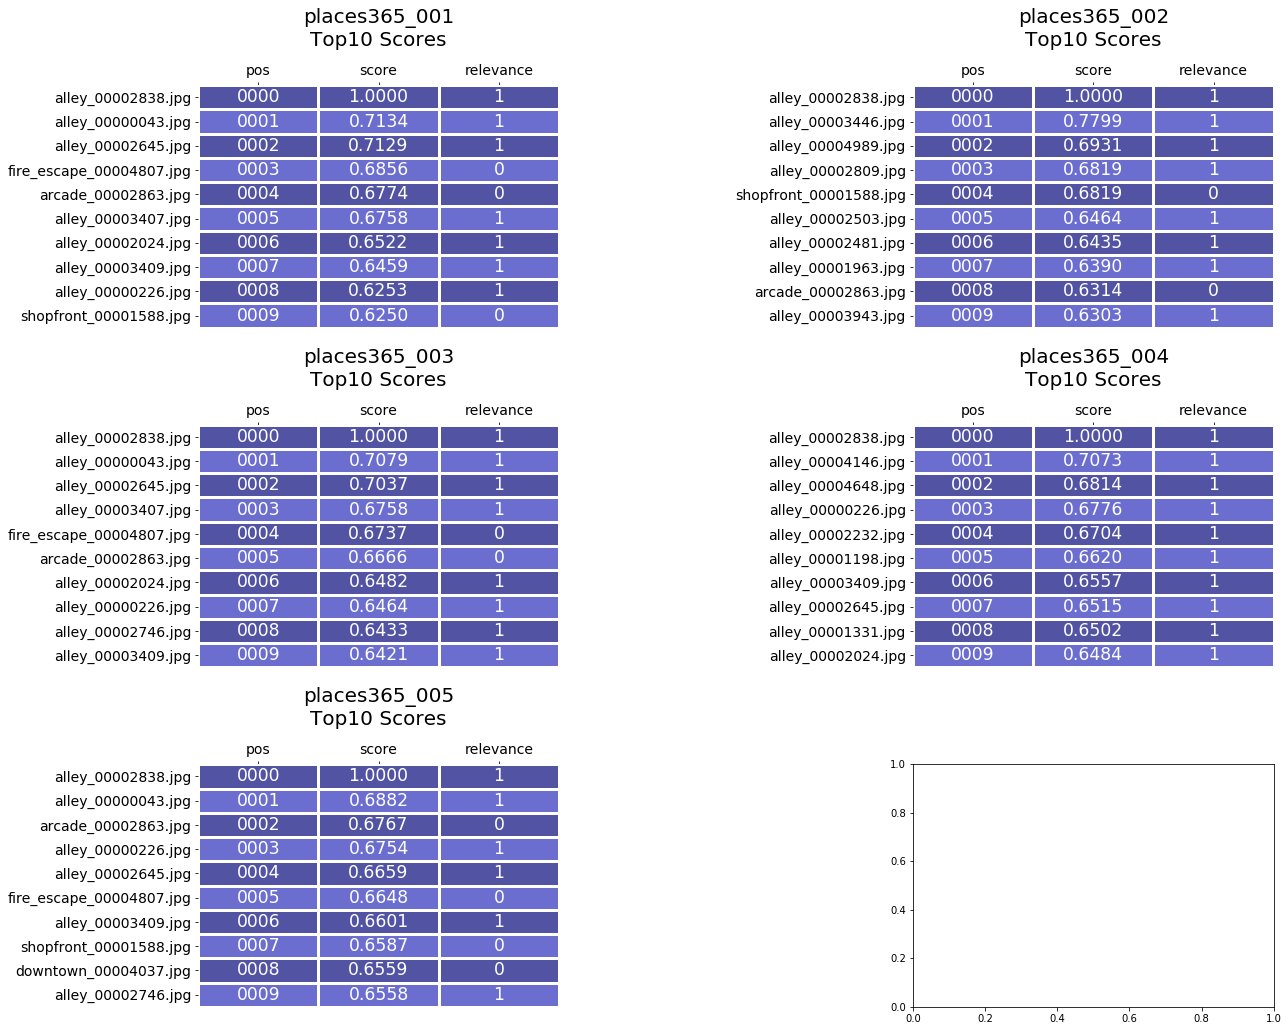

In [11]:
fig, axes = plt.subplots(3, 2)
axes = axes.reshape(-1)
fig.set_size_inches(19, 16)

for i, k in enumerate(keys):
    
    ax = axes[i]
    
    im = tableimg((topk, 3), rnamelist[i], ['pos', 'score', 'relevance'], ax=ax, 
                  gridwidth=3.0, title="{0:s}\nTop{1:d} Scores".format(keys[i], topk, exname), 
                  colorkw=dict(cmap='tab20b', cidx=[1, 2]), aspect='auto')
    
    tablearray = [np.arange(topk, dtype=np.int32), 
                  rscorelist[i].reshape(-1),
                  rlabellist[i].reshape(-1)]
    
    texts = annotate_tableimg(im, tablearray, colfmt=["{x:04d}", "{x:.4f}", "{x:d}"], 
                              **dict(fontsize='xx-large', color='white'))


#for i, k in enumerate(keys):
    #ax = axes[i]
    
    #im = heatmap(rscorelist[i].reshape(-1, 1), rnamelist[i], '', ax=ax, gridwidth=0.0,
             #title="{0:s}\nTop{1:d} Scores".format(keys[i], topk, exname), cmap='Purples', aspect='auto')
    
    #texts = annotate_heatmap(im, valfmt="{x:.4f}", textcolors=['black', 'white'], **dict(fontsize='large'))
fig.tight_layout()

plt.subplots_adjust(left=0.2, top=0.9, bottom=0.1, wspace=0.98, hspace=0.4)
plt.savefig('/home/alberto/phD/projects/performance_prediction/ret-mr-learning/misc./{0:s}_ranks.svg'.format(exname))

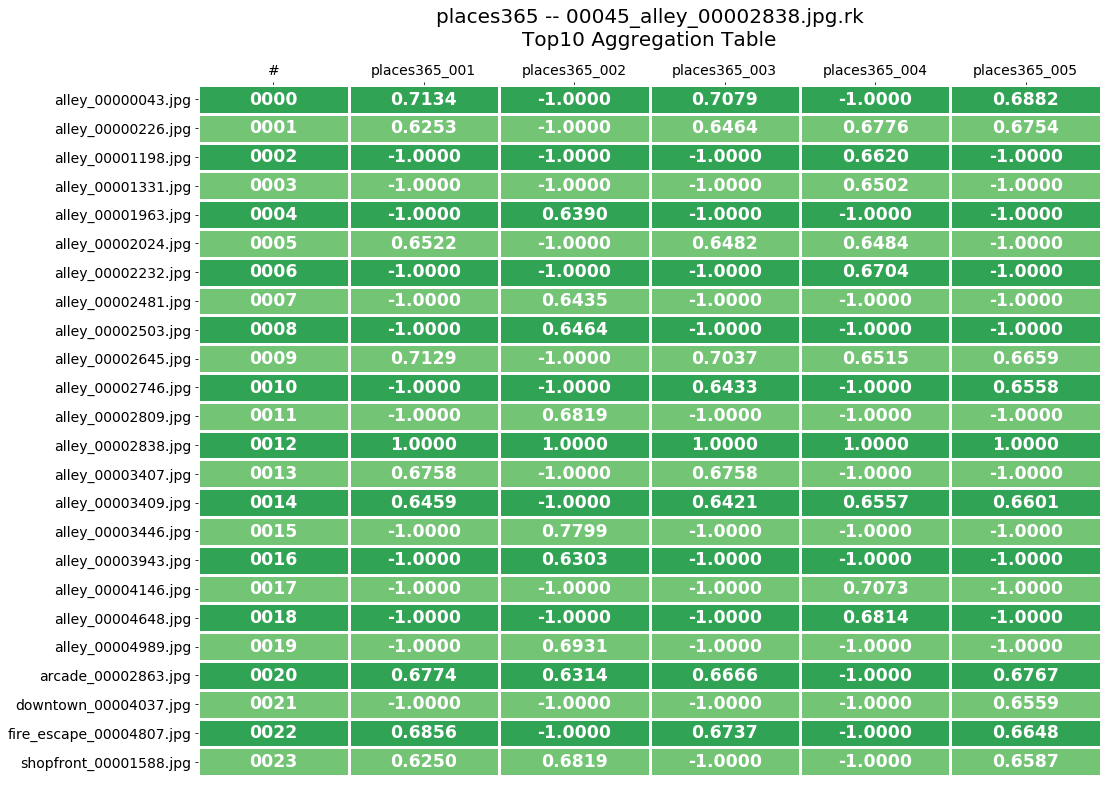

In [12]:
a_names, a_scores, a_labels = create_aggr_table(rnamelist, rscorelist, rpredlist)


fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
fig.tight_layout()

r = a_names.shape[0]

im = tableimg((r, 1 + len(keys)), a_names, ['#'] + keys, ax=ax, 
              gridwidth=3.0, title="{0:s} -- {1:s}\nTop{2:d} Aggregation Table".format(collection, exname, topk), 
              colorkw=dict(cmap='tab20c', cidx=[8, 9]), aspect='auto')

table = [np.arange(r, dtype=np.int32)] + [a_scores[:, i] for i in range(a_scores.shape[1])]

texts = annotate_tableimg(im, table, colfmt=["{x:04d}"] + ["{x:.4f}"]*5 + ["{x:d}"], 
                          **dict(fontsize='xx-large', color='white', weight='bold'))

plt.subplots_adjust(left=0.2, top=0.9, bottom=0.1)
plt.savefig('/home/alberto/phD/projects/performance_prediction/ret-mr-learning/misc./{0:s}_agg_tbl.svg'.format(exname))

places365_001 : P@10 = 0.700 [07] : AP = 0.844 -- Prd.P@10 = 0.000 [00] : Prd.AP = nan
places365_002 : P@10 = 0.800 [08] : AP = 0.921 -- Prd.P@10 = 0.500 [05] : Prd.AP = 1.000
places365_003 : P@10 = 0.800 [08] : AP = 0.880 -- Prd.P@10 = 0.000 [00] : Prd.AP = nan
places365_004 : P@10 = 1.000 [10] : AP = 1.000 -- Prd.P@10 = 0.100 [01] : Prd.AP = 1.000
places365_005 : P@10 = 0.600 [06] : AP = 0.811 -- Prd.P@10 = 0.100 [01] : Prd.AP = 1.000


combSUM
P@10 = 0.700 | AP@10 = 0.821
P@24 = 0.833 | AP@24 = 0.807
combMNZ
P@10 = 0.700 | AP@10 = 0.821
P@24 = 0.833 | AP@24 = 0.807
combSUMPlus_zero
P@10 = 0.800 | AP@10 = 0.797
P@24 = 0.833 | AP@24 = 0.802


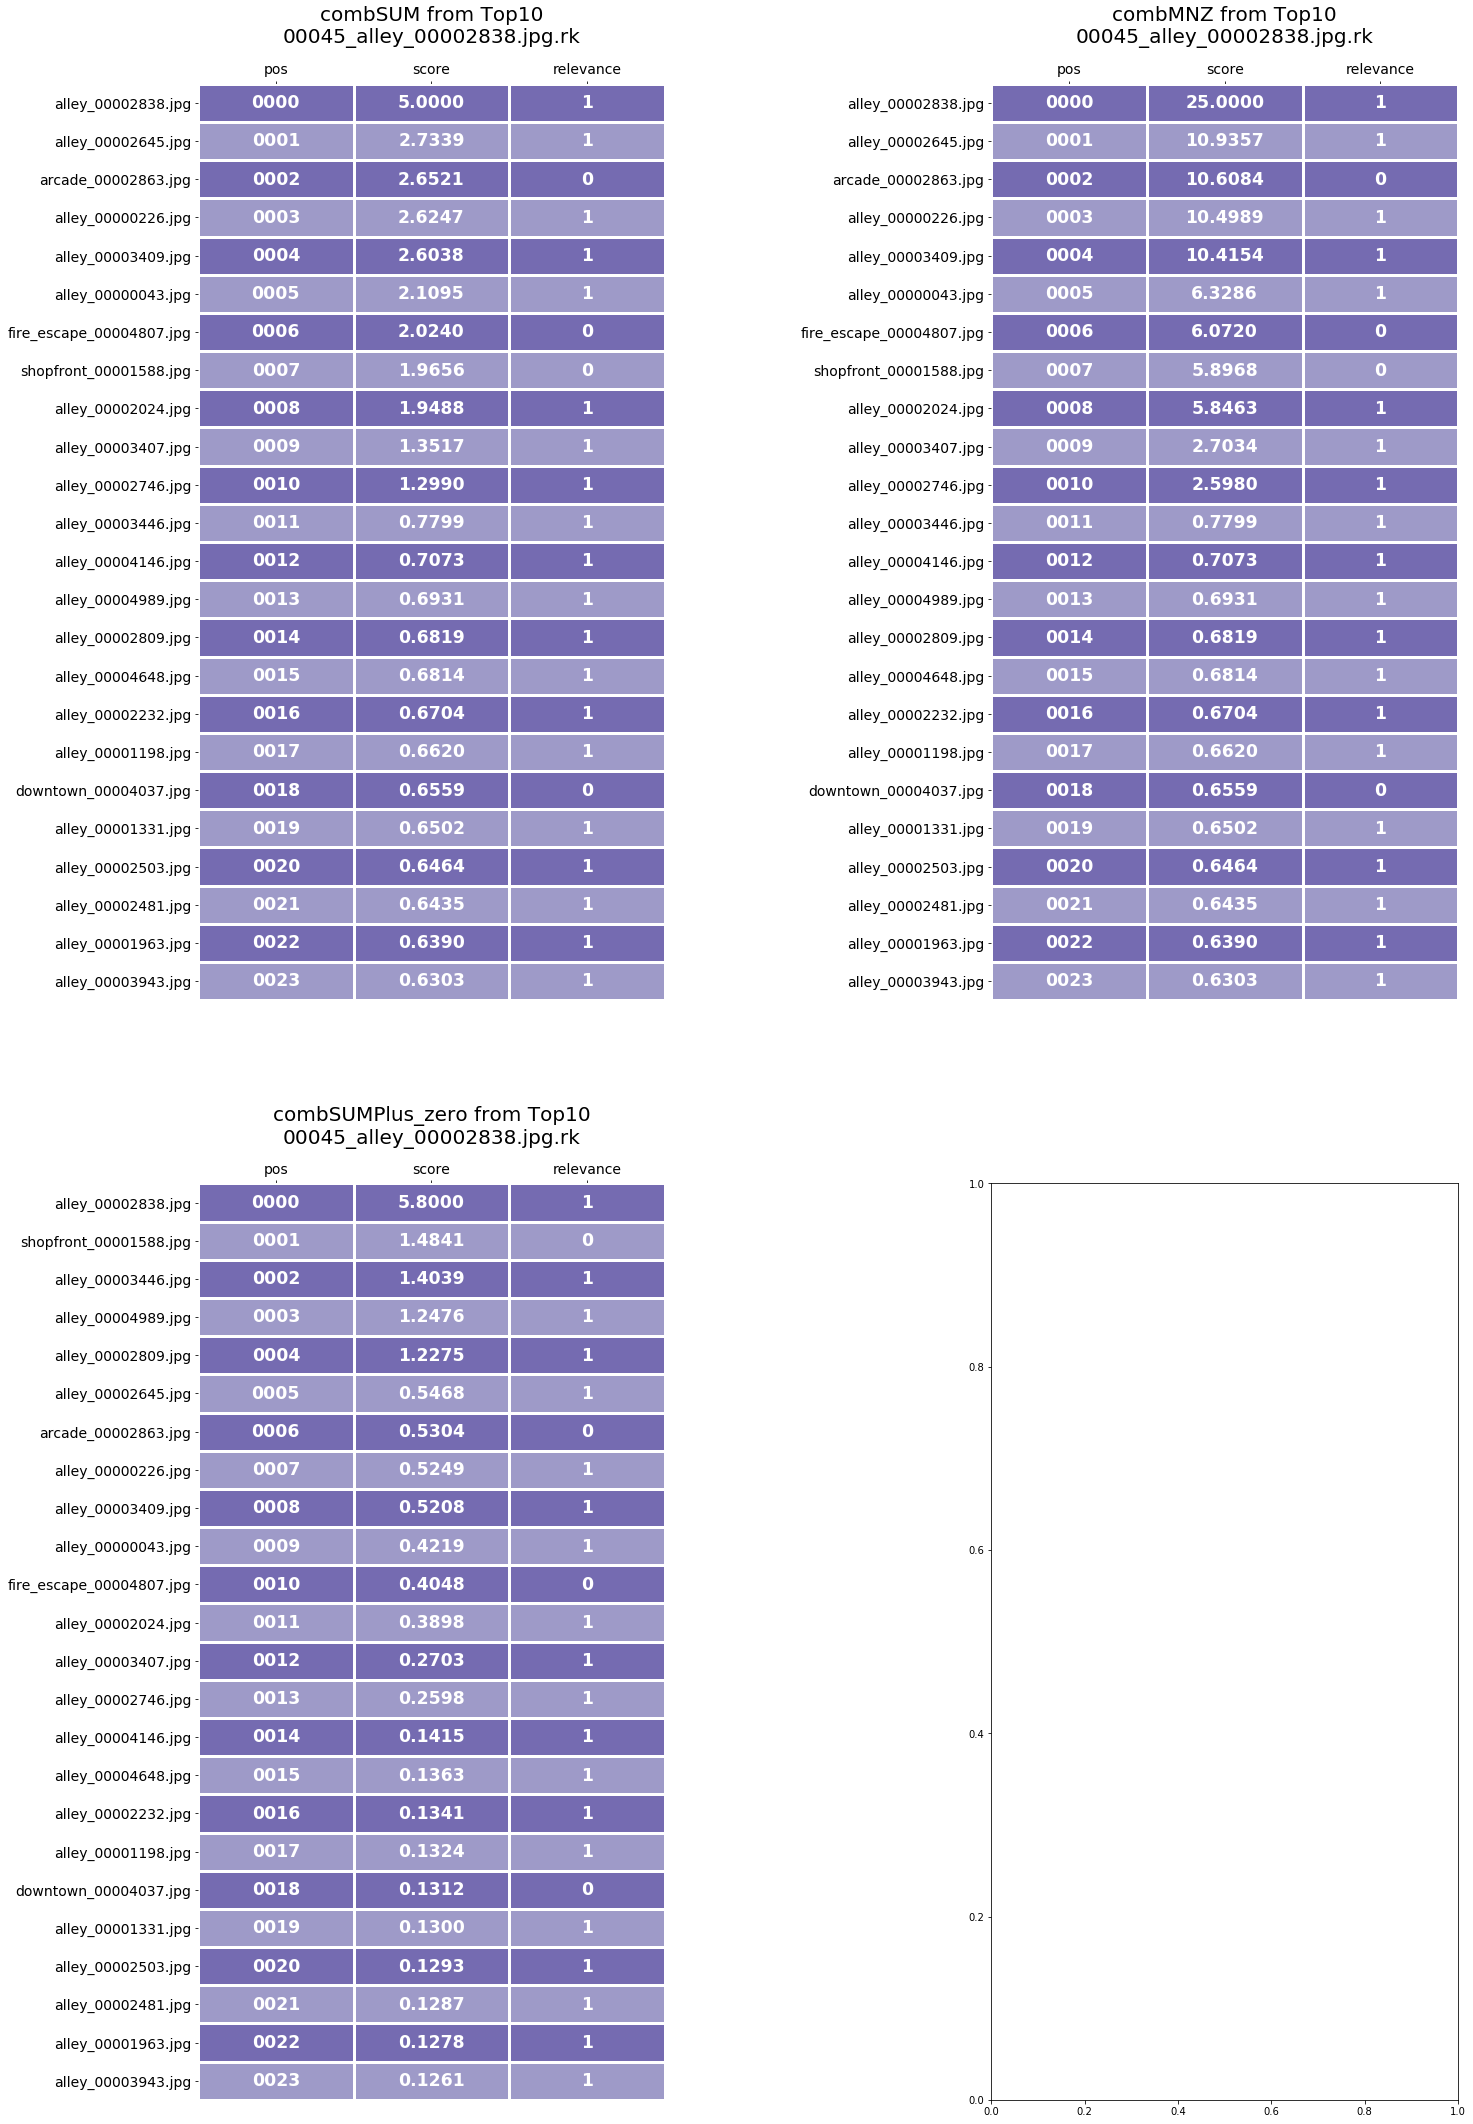

In [13]:
for k in resmap:
    print("{0:s} : P@{1:d} = {2:0.3f} [{3:02d}] : AP = {4:0.3f} -- Prd.P@{1:d} = {5:0.3f} [{6:02d}] : Prd.AP = {7:0.3f}"
          .format(k, topk, resmap[k][0], resmap[k][1], resmap[k][2], resmap[k][3], resmap[k][4], resmap[k][5]))
print('\n')
    
agg_func_map = dict(combSUM=(aggr_combSUM, dict()), 
                    combMNZ=(aggr_combMNZ, dict()),
                    combSUMPlus_zero=(aggr_combSUM_plus, dict(aggr_labels=a_labels, f=0.8)))
                    #combSUMPlus_pos=(aggr_combSUM_plus, dict(aggr_labels=a_labels, f=0.8, balance=1)),
                    #combSUMPlus_neg=(aggr_combSUM_plus, dict(aggr_labels=a_labels, f=0.8, balance=-1))
                   #)

fig_rows = int(np.ceil(len(agg_func_map)/2))

fig, axes = plt.subplots(fig_rows, 2)
axes = axes.reshape(-1)
fig.set_size_inches(35, 35)
fig.tight_layout()

for i, func_name in enumerate(agg_func_map.keys()):
    
    agg_func, kw = agg_func_map[func_name]
    
    comb_names, comb_scores = agg_func(a_names, a_scores, **kw)
    
    labels = labels_from_map(labelmap, comb_names)

    apat_topk = average_precision_score(labels[0:topk], np.linspace(1.0, 0.0, topk), pos_label=1)
    apat_all = average_precision_score(labels, np.linspace(1.0, 0.0, labels.size), pos_label=1)
    
    ax = axes[i]

    r = comb_names.shape[0]

    im = tableimg((r, 3), comb_names, ['pos', 'score', 'relevance'], ax=ax, 
                  gridwidth=3.0, title="{2:s} from Top{0:d}\n{1:s}".format(topk, exname, func_name), 
                  colorkw=dict(cmap='tab20c', cidx=[12, 13]), aspect='auto')

    tablearray = [np.arange(r, dtype=np.int32), 
                  comb_scores.reshape(-1),
                  labels.reshape(-1)]

    texts = annotate_tableimg(im, tablearray, colfmt=["{x:04d}", "{x:.4f}", "{x:d}"], 
                              **dict(fontsize='xx-large', color='white', weight='bold'))
    
    print(func_name)
    print("P@{0:d} = {1:0.3f} | AP@{0:d} = {2:0.3f}".format(topk, np.sum(labels[0:topk])/topk, apat_topk))
    print("P@{0:d} = {1:0.3f} | AP@{0:d} = {2:0.3f}".format(labels.size, np.sum(labels)/labels.size, apat_all))

plt.subplots_adjust(left=0.3, right=0.8, top=0.9, bottom=0.1, hspace=0.2, wspace=0.7)
#plt.savefig('/home/alberto/phD/projects/performance_prediction/ret-mr-learning/misc./{0:s}_cumbsum3.svg'.format(exname))